In [1]:
using JuMP
import SCS
import LinearAlgebra

using Plots
import MathOptInterface
const MOI = MathOptInterface
using MosekTools

In [3]:
using Random

In [105]:
Random.seed!(2022)


MersenneTwister(2022)

## Facility Location 

In [106]:

m = 3 # number of locations of clients
n = 2 # dimension

p = 1.5 # distance norm

C = rand(m, n) # generate location matrix



3×2 Matrix{Float64}:
 0.798259  0.174948
 0.899849  0.476416
 0.150106  0.507665

In [107]:
# minimize 1-norm 
model = Model(Mosek.Optimizer)
set_silent(model)
@variable(model, y[1:n])

@variable(model, delta[1:m])

@objective(model, Min, sum(delta))


@variable(model, t[1:m, 1:n])
@constraint(model, sum(t, dims=2) .<= delta)
for j in 1:m
    for i in 1:n
        @constraint(model, t[j,i] >= y[i]-C[j,i] )
        @constraint(model, t[j,i] >= -y[i]+C[j,i] )
    end
end

optimize!(model)

@show objective_value(model)

objective_value(model) = 1.0824588432821156


1.0824588432821156

[0.7982589547203987, 0.47641562250130376]


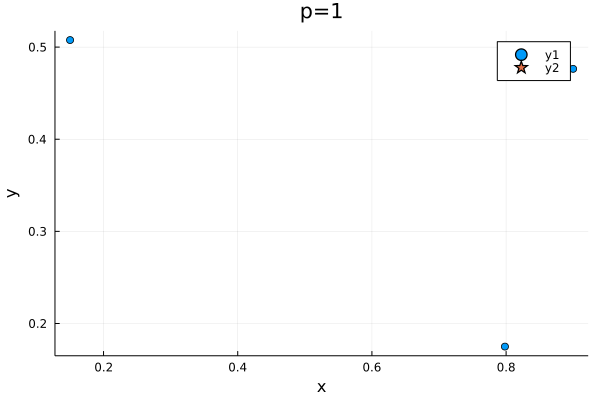

In [108]:
y_sol = value.(y)
println(y_sol)
gr() # We will continue onward using the GR backend
plot(C[:,1], C[:,2], seriestype = :scatter)
plot!([y_sol[1]], [y_sol[2]], seriestype = :scatter, markershape = :star)
xlabel!("x")
ylabel!("y")

title!("p=1")

In [109]:
# minimize 2-norm
model = Model(Mosek.Optimizer)
set_silent(model)
@variable(model, y[1:n])

@variable(model, delta[1:m])

@objective(model, Min, sum(delta))


for j in 1:m
    
    @constraint(model, [delta[j]; y-C[j,:]] in SecondOrderCone() )

end

optimize!(model)

@show objective_value(model)


objective_value(model) = 0.9972610708382081


0.9972610708382081

[0.756958486088239, 0.3369880015464145]


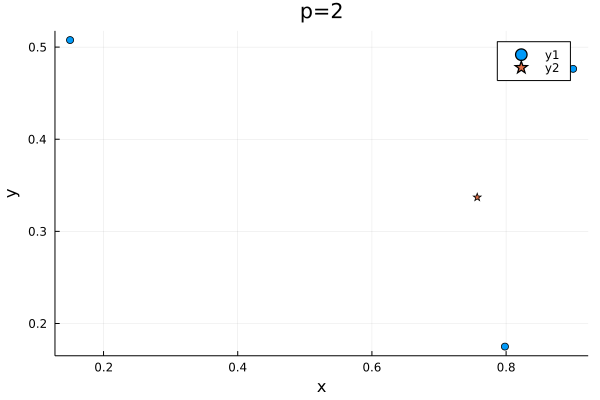

In [110]:
y_sol = value.(y)
println(y_sol)

plot(C[:,1], C[:,2], seriestype = :scatter)
plot!([y_sol[1]], [y_sol[2]], seriestype = :scatter, markershape = :star)
xlabel!("x")
ylabel!("y")

title!("p=2")

In [111]:
model = Model(Mosek.Optimizer)
set_silent(model)
@variable(model, y[1:n])

@variable(model, delta[1:m])

@objective(model, Min, sum(delta))


@variable(model, t[1:m, 1:n])
@constraint(model, sum(t, dims=2) .<= delta)
for j in 1:m
    for i in 1:n
        @constraint(model, [t[j,i]; delta[j]; y[i]-C[j,i]] in MOI.PowerCone(1/p) )
    end
end

optimize!(model)
@show objective_value(model)

objective_value(model) = 1.042393178204192


1.042393178204192

[0.7965220471892577, 0.42356199766789526]


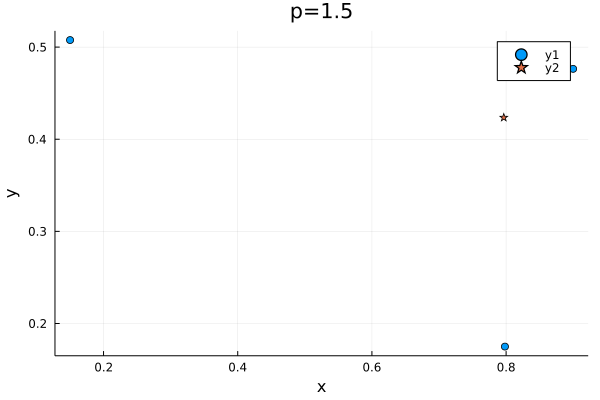

In [112]:
y_sol = value.(y)
println(y_sol)
plot(C[:,1], C[:,2], seriestype = :scatter)
plot!([y_sol[1]], [y_sol[2]], seriestype = :scatter, markershape = :star)
xlabel!("x")
ylabel!("y")

title!("p=$(p)")

## Sparse Linear Regression Problems

In [139]:
n = 1000
m = 100

x_true = rand(n)
x_true[rand(n) .> 0.01] .= 0
println(sum(x_true .> 0))

A = rand(m, n)
b = A * x_true

100-element Vector{Float64}:
 1.5560990399043142
 1.282649664472874
 0.6243874031911918
 1.2578696806258765
 1.6384735358651359
 1.2703927743421695
 0.6754466825381882
 1.3380200791311472
 1.8167944060778658
 1.2845020160329035
 1.4507224063694852
 1.0290239750816226
 1.0838173450890274
 ⋮
 1.4701106789295073
 1.5896934823882463
 1.2446933759464718
 0.9762844072382904
 1.0310860624420417
 1.881292603387256
 0.6210165963203973
 0.7959411804532079
 1.452218338893696
 1.7765682707078834
 1.6333125620704956
 1.5937867443851705

In [140]:
model = Model(Mosek.Optimizer)
set_silent(model)
@variable(model, x[1:n])

@variable(model, t[1:n])

@constraint(model, A * x .== b)
@constraint(model, x .<= t)
@constraint(model, -x .<= t)
@objective(model, Min, sum(t))

optimize!(model)

@show objective_value(model)

objective_value(model) = 2.528861930486995


2.528861930486995

In [141]:
x_sol = value.(x)

LinearAlgebra.norm(x_sol - x_true)/ LinearAlgebra.norm(x_true)

6.439447035774298e-11

## Data Classification: Supporting Vector Machine

In [146]:
using Distributions

In [168]:
n = 2
m = 50

X = rand(Uniform(-1,1), m, n)



temp = rand(n, n)
A_true = temp * temp'

y = zeros(m)

for i in 1:m
    y[i] = (X[i,:]' * A_true * X[i,:] < 0.5)
    
end

idx0 = findall(x->x==0, y)
idx1 = setdiff(1:m, idx0)



31-element Vector{Int64}:
  1
  3
  4
  5
  7
  9
 10
 11
 12
 15
 16
 19
 20
  ⋮
 35
 39
 40
 41
 42
 43
 45
 46
 47
 48
 49
 50

In [201]:
"""
    get_ellipse_point(S)

Given a quadratic equation of form x'Sx ≤ r. Get the x and y coordinates for plotting. `S` needs to be positive definite.
"""
function get_ellipse_point(S, r=1.0)
    c = range(0, 2π; length = 1000) .|> [cos sin] |> permutedims #Create Basic Circle
    #c = c .+ shift
    c = c .* sqrt(r)
    f = LinearAlgebra.eigen(S)
    Λ = LinearAlgebra.Diagonal(f.values .^(-0.5))
    P = f.vectors
    return P*Λ*c |> eachrow
end

x_array, y_array = get_ellipse_point(A_true, 0.5)




Base.Generator{Base.OneTo{Int64}, Base.var"#191#192"{Matrix{Float64}}}(Base.var"#191#192"{Matrix{Float64}}([1.7214781257477754 1.7181993538251645 … 1.7246888005359007 1.7214781257477756; -2.5898538712860053 -2.5919594178342766 … -2.587645876948979 -2.5898538712860053]), Base.OneTo(2))

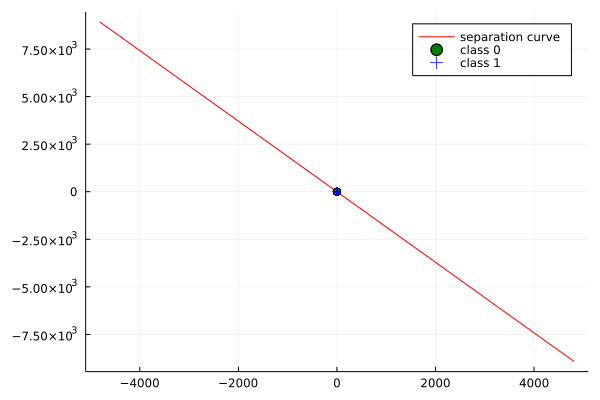

In [222]:
plot(x_array, y_array, color = :red, label="separation curve")
plot!(X[idx0,1], X[idx0,2], seriestype=scatter, markershape = :circle, markercolor = :green, label="class 0")

plot!(X[idx1,1], X[idx1,2], seriestype=scatter, markershape = :cross, markercolor = :blue, label="class 1" )



In [216]:
mu = 0


model = Model(Mosek.Optimizer)

@variable(model, beta == 0)
@variable(model, A[1:n,1:n], PSD)
@variable(model, a[1:n])
@variable(model, a0)

for i in idx0
    @constraint(model, X[i,:]' * A * X[i,:] >= 0.5)#+ X[i,:]' * a + a0 + beta >= 1)
end

for i in idx1
    @constraint(model, X[i,:]' * A * X[i,:] <= 0.5)# + X[i,:]' * a + a0 - beta <= -1)
end

@variable(model, t >= 0)
@constraint(model, [t;a] in SecondOrderCone())

#eye = Matrix{Float64}(LinearAlgebra.I, n, n);
@objective(model, Min, mu*beta + LinearAlgebra.tr(A) + t*t)
optimize!(model)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 53              
  Cones                  : 2               
  Scalar variables       : 9               
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimizat

In [217]:
@show value(beta)
@show value.(a0)
@show value.(a)
@show value.(A)

value(beta) = 0.0
value.(a0) = 0.0
value.(a) = [0.0, 0.0]
value.(A) = [0.9634937183651128 0.5196034341521356; 0.5196034341521356 0.28021743130332044]


2×2 Matrix{Float64}:
 0.963494  0.519603
 0.519603  0.280217

In [219]:
A_sol = value.(A)

A_true

2×2 Matrix{Float64}:
 0.963494  0.519603
 0.519603  0.280217

In [220]:
LinearAlgebra.cholesky(value.(A))

LinearAlgebra.Cholesky{Float64, Matrix{Float64}}
U factor:
2×2 LinearAlgebra.UpperTriangular{Float64, Matrix{Float64}}:
 0.981577  0.529356
  ⋅        7.92708e-5

In [226]:
LinearAlgebra.eigen(A_sol)

LinearAlgebra.Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
2-element Vector{Float64}:
 4.868062841723031e-9
 1.2437111448003704
vectors:
2×2 Matrix{Float64}:
  0.474666  -0.880166
 -0.880166  -0.474666

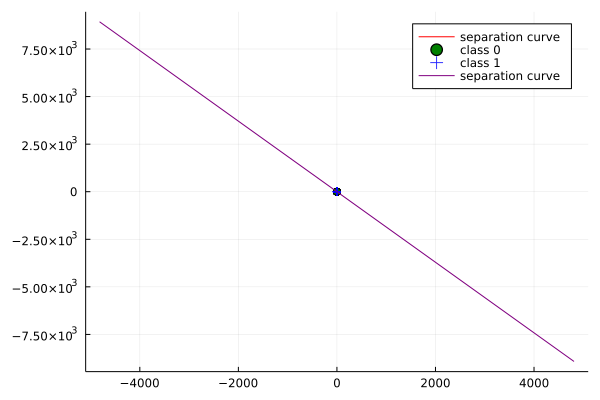

In [221]:

x_array, y_array = get_ellipse_point(A_sol, 0.5)


plot!(x_array, y_array, color = :purple, label="separation curve")



## Logistic Regression

LinearAlgebra.UniformScaling{Bool}
true*I